##  Clinical Diagnosis Prediction from Medical Transcripts/Anamnesis
#### Member: Joy Zhuge, Gemeng Zhang

### Background

Primary health care is essential for most people, but making an appointment with a doctor could be exhausting and time-consuming in modern life. It would be great to have an AI healthcare chatbot to assure the anxiety before making the reservation. Image the scenario, we can make a self-diagnosis right after having some symptoms, and then decide which specialists to visit.
We attempt to predict clinical diagnosis from medical transcripts/anamnesis, although the prediction might not be accurate at all. On one side, patients can save time and money with a positive attitude; on the other side, doctors can serve more efficiently on sparing time on unreliable diagnosis.


### Dataset Info

We will use the medical transcription sample reports and examples from https://www.mtsamples.com. The data contains around 5000 sample transcription reports for many specialties provided by various transcriptionists and users and are for reference purpose only. The data is also available on Kaggle (https://www.kaggle.com/tboyle10/medicaltranscriptions) . In our problem setting, we are interested in two aspects of the data: the sample medical transcription as features and medical speciality as labels. In the dataset, 40 types of specialties are provided as labels with an unbalanced distribution ((min,max) = (7, 1103)).

In [26]:
# Dependent libraries
# Basic libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import random
import itertools
from collections import defaultdict
import string

# Preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
import gensim.downloader as api
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

# Models

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
import lightgbm as lgb

# Evaluation

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Data Preview

In [2]:
# load data
data = pd.read_csv('mtsamples.csv')
print(data.shape)
data.head()

(4999, 6)


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


After the load the dataset, we can see there are five columns including the "description", "medical_specialty", "sample_name", "transcription" and "keywords". In our project, we are interested in predicting the medical specialty according to the transcription records, so we will only keep those two columns for further use. Moreover, we would like to check if there are any empty entry in the left two columns and discard those entries accordingly.

In [3]:
# extract the medical specialty and transcriptions
data = data[['transcription', 'medical_specialty']]

# remove the data entry with NaN
data = data.drop(data[data['transcription'].isna()].index)
data = data.drop(data[data['medical_specialty'].isna()].index)
print(data.shape)

(4966, 2)


It seems 33 data porints were removed due to the empty entry! Now, let's take a look at our feature, the transcription context. Although it should be vectorized for further modeling, clearly understanding of the words is the pivot for successful feature extraction. The transcription is the detailed description of patients' symptoms from the physicians or doctors. For example, we can show the transcription for the first patient in the list. We can see there are several keywords appearing in the context like "SUBJECTIVE", "MEDICATIONS","ALLERGIES","OBJECTIVE", "ASSESSMENT" and "PLAN", which seems to be a very well-organized text form.


In an ideal condition, we would like the transcription to be a highly structured form, which will be in favor of further analysis. However, we found this tale is not applicable in this pratice as we check more patients data. The transcription of the second patients just has a different list of record: PAST MEDICAL HISTORY, "PAST SURGICAL HISTORY","SOCIAL HISTORY", "FAMILY HISTORY","CURRENT MEDICATIONS", "ALLERGIES","MISCELLANEOUS/EATING HISTORY","REVIEW OF SYSTEMS","PHYSICAL EXAMINATION". There is no doubt that it would be problematic if we just ignore those KEYWORDS and throw the whole paragraph into featurization. It seems we must firstly find a way to make use of (or skip) those KEYWORDS in our featurization. 

In [4]:
data.iloc[2]['transcription']

'HISTORY OF PRESENT ILLNESS: , I have seen ABC today.  He is a very pleasant gentleman who is 42 years old, 344 pounds.  He is 5\'9".  He has a BMI of 51.  He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at his lowest 260.  He is pursuing surgical attempts of weight loss to feel good, get healthy, and begin to exercise again.  He wants to be able to exercise and play volleyball.  Physically, he is sluggish.  He gets tired quickly.  He does not go out often.  When he loses weight he always regains it and he gains back more than he lost.  His biggest weight loss is 25 pounds and it was three months before he gained it back.  He did six months of not drinking alcohol and not taking in many calories.  He has been on multiple commercial weight loss programs including Slim Fast for one month one year ago and Atkin\'s Diet for one month two years ago.,PAST MEDICAL HISTORY: , He has difficulty climbing stairs, difficulty with airline seats, tying sho

Similarly, we can check the meidcal specialty of the data. From the following results, we can see this is a unbalanced multi-classfication problem. There are total 40 labels containing 6 to 1088 samples in different classes. Hence, we also need to take this into consideration in our performance measure and classifier design.

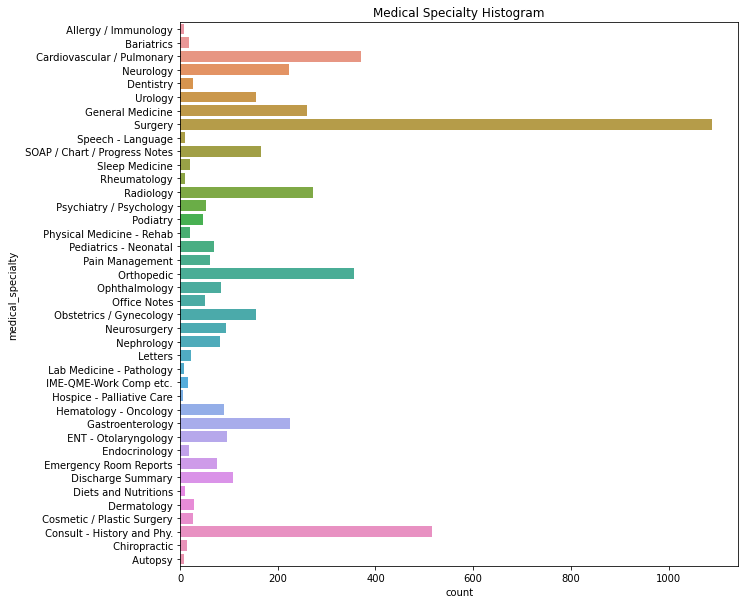

There are total of 40 labels for medical specialty
 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Dentistry   

In [14]:
fig = plt.figure(figsize=(10, 10)) 
plt.title('Medical Specialty Histogram')
plt.xlabel('Specialty Category')
plt.ylabel('Counts')
#plt.hist(data['medical_specialty'], edgecolor = 'black', bins = 20)
sns.countplot(y='medical_specialty', data = data )
plt.show()

print('There are total of', len(data['medical_specialty'].value_counts()), 
      'labels for medical specialty')
print(data['medical_specialty'].value_counts())

To make the transcription more clear and easier to tokenize, we would like to clean the dat in the following ways:
1. turn all the words into lower case
2. remove all the punctuations
3. remove all the numbers

In [15]:
translator_c = str.maketrans(string.punctuation, ' '*len(string.punctuation))
data['transcription_clear']=data['transcription'].apply(lambda x: ' '.join([i for i in str(x).lower().
                                            translate(translator_c).split(' ') if i.isalpha()]))

In [16]:
data.head(5)

,transcription,medical_specialty,transcription_clear
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology,subjective this year old white female presents...
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics,past medical history he has difficulty climbin...
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics,history of present illness i have seen abc tod...
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary,d m mode left atrial enlargement with left atr...
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary,the left ventricular cavity size and wall thic...


### Vectorization/Embedding

### Bag of words
Bag of Words takes a document from corpus and converts into a numeric vector by mapping each document word to a feature vector.

In [20]:
bow_vect=CountVectorizer()
bow_vect.fit(data)
bow_x=bow_vect.transform(data['transcription_clear'].tolist())
bow_y=data['medical_specialty'].tolist()
bow_x

<4966x3 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

### TF-IDF
The bags of words method is simple and straight forward, but it treats all words equally that can't ditingush the common words like 'the','a' or rare words. The term frequency-inverse document frequency(tf-idf) method measures a word depending on how frequency it occurs in a document and a corpus.
1. Term frequency measures the frequency of a word in a document---tf('word_i')=number of times of ‘word_i’ appears in document / total number of words in a document
2. Inverse document frequency measure how common of a word is across all the document in the corpus---idf('word_i')=log(number of total documents / number of a document with ‘word_i’ in it))
3. tf-idf('word_i')=tf('word_i') * idf('word_i')

Suppose word 'the' is present in all the 100 documents, idf('the')=log(100/100)=log1=0, in that case, the very common words tend to be lesser important.

In [22]:
tfidf_vect=TfidfVectorizer()
tfidf_vect.fit(data)
tfidf_x=tfidf_vect.transform(data['transcription_clear'].tolist())
tfidf_y=data['medical_specialty'].tolist()
tfidf_x

<4966x3 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

### Word2Vec
copied from hw2

In [27]:
w2v = gensim.downloader.load('glove-wiki-gigaword-50')

In [28]:
def average_vectors(words, w2v):
    vectors_sum=np.zeros(len(w2v['the']))
    for word in words:
        temp=w2v[word]
        vectors_sum+=temp
    vectors_average=vectors_sum/(len(words))
    return vectors_average

def max_vectors(words, w2v): 
    temp=np.zeros((len(words),len(w2v['the'])))
    for index, word in enumerate(words):
        temp[index]=w2v[word]
    vectors_max=np.array([max(idx) for idx in zip(*temp)])
    return vectors_max

def min_vectors(words, w2v):
    # YOUR CODE HERE
    temp=np.zeros((len(words),len(w2v['the'])))
    for index, word in enumerate(words):
        temp[index]=w2v[word]
    vectors_min=np.array([min(idx) for idx in zip(*temp)])
    return vectors_min

def min_max_vectors(words, w2v):
    # YOUR CODE HERE
    temp=np.zeros((len(words),len(w2v['the'])))
    for index, word in enumerate(words):
        temp[index]=w2v[word]
    vectors_min=np.array([min(idx) for idx in zip(*temp)])
    vectors_max=np.array([max(idx) for idx in zip(*temp)])
    vectors_min_max=np.concatenate((vectors_min,vectors_max))
    return vectors_min_max

In [33]:
def make_word_vector_features(X, vocab, w2v, aggregation_fn):
    """
    a numpy.ndarray with n rows and d columns, where n is the number of documents
    in X and d is the word vector dimension resulting from aggregation_fn
    """
    # YOUR CODE HERE
    mylist=[]
    for i in range(X.shape[0]):
        words=vocab[X[i].indices]
        temp=aggregation_fn(words, w2v)
        mylist.append(temp)
    fn=np.array(mylist)
    return fn

In [36]:
vocab = np.array(bow_vect.get_feature_names())
w2v_vec = make_word_vector_features(bow_x, vocab, w2v, average_vectors)